TODO:
 * precompute $\log|\Sigma_i|$
 * precomute swapped indices for parameter updates

In [1]:
using Distributions
using Seaborn

import CSV
import JLD2
import Base.Filesystem: joinpath

In [2]:
include("src/NGSIM.jl")

Base.Nullable{T}) in module Base at nullable.jl:238 overwritten in module NullableArrays at C:\Users\Hamza El-Saawy\.julia\v0.6\NullableArrays\src\operators.jl:128

chmm_em! (generic function with 1 method)

.


In [5]:
DATA_PATH = "../data/trajdata_i101_trajectories-0750am-0805am"
JLD2.@load joinpath(DATA_PATH, "td.jld") td

(S, id_lookup) = td_sparse(td)

X_full = CSV.read(joinpath(DATA_PATH, "X.csv"); nullable=false)
X = Array(X_full[:, [:velocity, :heading]])'

(pairs, _) = readcsv(joinpath(DATA_PATH, "pairs.csv"), Int; header=true)
pairs = pairs'
;

In [6]:
xs = X_full[:x]
ys = X_full[:y]
dx = X_full[:velocity] .* cos.(X_full[:heading])
dy = X_full[:velocity] .* sin.(X_full[:heading])
;

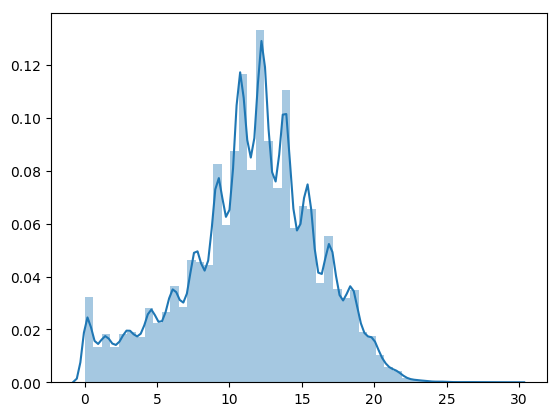

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000001B40B38>

In [56]:
distplot(X[1, :])

## EM

In [9]:
K = 5
curr = chmm_from_data(X, K)
suff = ChmmSuffStats(curr)
;

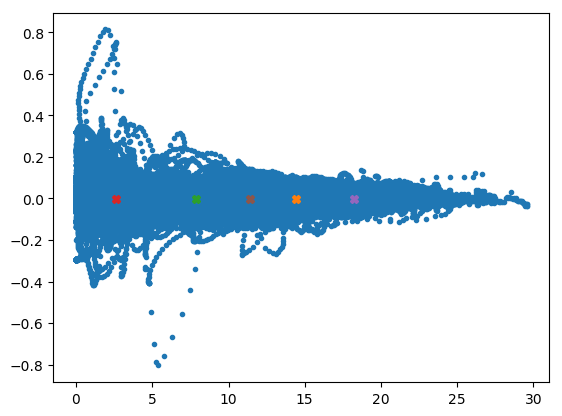

In [10]:
plot(X[1, :], X[2, :], ".")
for i in 1:K
    plot(curr.μs[i][1],curr.μs[i][2], "X")
end

In [17]:
N_iters=5

5

In [18]:
    KK = K^2
    traj_ptr = S.colptr
    num_trajs = length(traj_ptr) - 1
    num_pairs = size(pairs, 2)

    log_p0 = log.(outer(curr.π0))

    log_P = empty(KK, KK)
    for k in 1:KK
        i, j = ind2sub((K, K), k)
        outer!(reshape(view(log_P, :, k), K, K), curr.P[:, i, j])
    end
    map!(log, log_P, log_P)

    T_max = maximum(diff(traj_ptr))

    log_b = empty(KK, T_max)
    log_α = similar(log_b)
    log_β = similar(log_b)
    γ = similar(log_b)

    log_like_hist = fill(NaN, N_iters)

;

In [19]:
        log_like = 0.0
        zero!(suff)

ChmmSuffStats([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Array{Float64,1}[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]], Array{Float64,2}[[0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0]])

In [24]:
e = 4

(c1, c2, start_frame, end_frame) = pairs[:, e]
X1 = get_trajectory_from_frame(S, X, c1, start_frame, end_frame)
X2 = get_trajectory_from_frame(S, X, c2, start_frame, end_frame)

T = size(X1, 2)

data_likelihood!(PairwiseTrajectory,curr, X1, X2, log_p0, log_P, log_b)            

log_like += forward_backward!(curr, T,log_p0, log_P, log_b, log_α, log_β, γ)

update_suff_stats!(PairwiseTrajectory, suff, X2, X2, log_p0, log_P, log_b, log_α, log_β, γ)

62

In [40]:
id = 3
Xt = get_trajectory_from_ptr(id, X, traj_ptr)
T = size(Xt, 2)

452

In [43]:
data_likelihood!(SingleTrajectory,
        curr, Xt, log_p0, log_P, log_b)

In [46]:
log_like += forward_backward!(curr, T,
        log_p0, log_P, log_b, log_α, log_β, γ)

-2247.1451330928594

In [52]:
update_suff_stats!(SingleTrajectory, suff, Xt,
        log_p0, log_P, log_b, log_α, log_β, γ)

In [55]:
update_parameter_estimates!(curr, suff, log_p0, log_P)

In [8]:
(curr, log_like_hist) = chmm_em!(S, X, pairs, K, curr, suff; N_iters=20, print_every=1)
;

iteration      1:  -14965755.819
iteration      2:  1152736.315
iteration      3:  2040274.656
iteration      4:  2353061.825
iteration      5:  2434223.027
iteration      6:  2454888.812
iteration      7:  2459960.806
iteration      8:  2460118.701
iteration      9:  2459184.406
iteration     10:  2457834.855
iteration     11:  2456428.820
iteration     12:  2455025.684
iteration     13:  2453710.977
iteration     14:  2452398.268
iteration     15:  2451113.173
iteration     16:  2449962.005
iteration     17:  2448982.959
iteration     18:  2448145.738
iteration     19:  2447430.403
iteration     20:  2446855.630


(Chmm(5, 2, [0.22174, 0.045916, 0.0832697, 0.46977, 0.179305], [0.990876 0.480482 … 0.5107 0.493219; 0.00317365 0.518683 … 0.000741038 0.000171041; … ; 0.0059439 0.00132744 … 0.487452 0.0123519; 0.0 1.96241e-17 … 0.00120872 0.492501]

[0.480482 0.00222765 … 0.0164637 0.00197794; 0.518683 0.99769 … 0.495468 0.494874; … ; 0.00132744 8.1657e-5 … 0.48802 0.0164281; 7.84965e-17 5.5383e-17 … 0.000104463 0.486988]

[0.489854 7.6408e-17 … 0.000510143 1.22527e-18; 1.14344e-16 0.536042 … 4.08776e-5 7.84176e-17; … ; 0.0247592 0.0410607 … 0.495559 0.0011356; 0.00506913 2.38775e-17 … 0.0143658 0.502397]

[0.5107 0.0164637 … 0.0071898 0.00197733; 0.000741038 0.495468 … 6.31826e-5 7.81747e-17; … ; 0.487452 0.48802 … 0.989749 0.498605; 0.00120872 0.000104463 … 0.00292692 0.497183]

[0.493219 0.00197794 … 0.00197733 0.0; 0.000171041 0.494874 … 1.95437e-17 0.0; … ; 0.0123519 0.0164281 … 0.498605 0.0057829; 0.492501 0.486988 … 0.497183 0.98973], Array{Float64,1}[[13.3796, -0.000726572], [17.5739, -0.0006

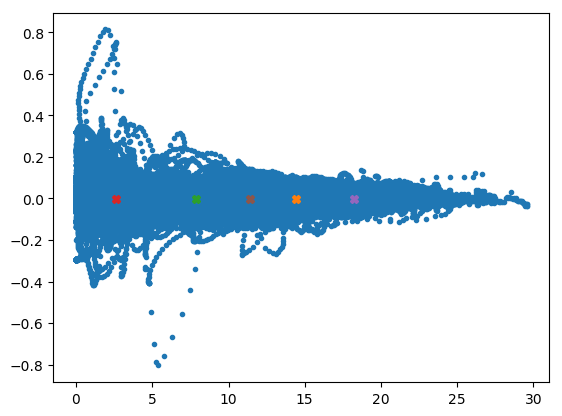

In [15]:
plot(X[1, :], X[2, :], ".")
for i in 1:K
    plot(curr.μs[i][1],curr.μs[i][2], "X")
end

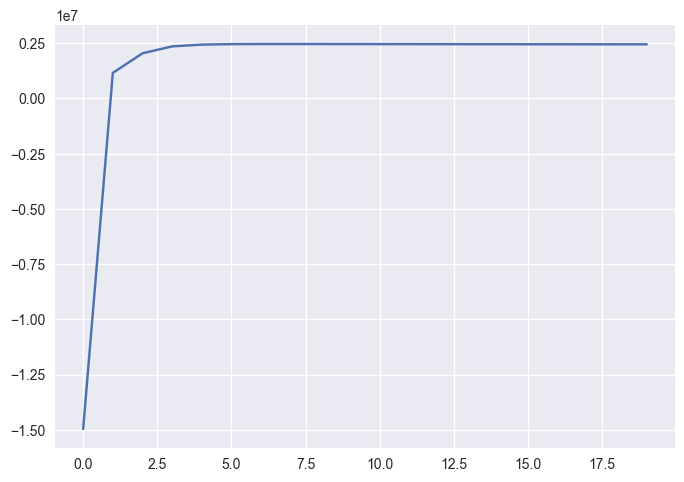

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000004E50080>

In [9]:
plot(log_like_hist)

# Analysis

In [43]:
true_to_est_lut = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est_lut[i] = indmin(r)
end

In [51]:
P_true = copy(model.P)
P_hat = copy( curr.P[true_to_est_lut, true_to_est_lut, true_to_est_lut] )
vecnorm(P_true .- P_hat)

0.7542858027583378

In [52]:
p0_true = copy(model.π0)
p0_hat = copy( curr.π0[true_to_est_lut] )
vecnorm(p0_true .- p0_hat)

0.260674987069303

In [53]:
hcat([model.μs[i] .- curr.μs[true_to_est_lut[i]] for i in 1:K] ...)

3×5 Array{Float64,2}:
 -0.00051745  -0.00585367  0.0127641   0.00533968   0.000901718
  0.00116878   0.0125749   0.00284204  0.00282913   0.00791609 
  0.00034659   0.00791029  0.0123829   0.00236185  -0.0124476  

In [55]:
vcat([vecnorm(model.Σs[i] .- curr.Σs[true_to_est_lut[i]]) for i in 1:K] ...)

5-element Array{Float64,1}:
 0.000492593
 0.0211899  
 0.0528093  
 0.00178972 
 0.0117793  